## Strategy
How will Strategy module will be used:

It will take a:
- df (the start and the ending date will be provided within the dataframe)
- type of objective function to use ('Sharpe Ratio', 'Multiple', ... any metrics)


It will contain methods:
- that will perform dynamic universe selection
- that will contain the trading strategy (will take the parameters as input)
- that will optimize for the best parameters given the objective function (will call the trading strategy method)\
-> Make sure to enforce the use of discrete parameters (by using an integer space (not real))\
-> Use BayesOptCV (cross validation, not Bayesian Optimization)
- that will perform the walk forward analysis (from sklearn.model_selection import TimeSeriesSplit)

It will output the strategy return column, position, cumulative return, trades, sessions, cumulative session return.


======================================================

Practical Recommendations
Low-Dimensional Problems (<5 dimensions):

init_points: 5–10
n_iter: 10–30
Moderate-Dimensional Problems (5–10 dimensions):

init_points: 10–15
n_iter: 30–50
High-Dimensional Problems (>10 dimensions):

Bayesian optimization might struggle due to the curse of dimensionality. Consider alternatives like random search or evolutionary algorithms if dimensions are very high.

======================================================

The key is to perform separate walk-forward analysis for both the strategies and the rebalancing process

---

In [1]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Data_Management'))) #We have a double .. as we are in the Strategy subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Risk_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Validation')))

# Import the modules
from data import Data
from calculations import Calculations, Metrics
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit
from manage_trade import Manage_Trade
from position import Position
from testing import WFO

Skipping category 'layer-1', already processed.
Skipping category 'depin', already processed.
Skipping category 'proof-of-work-pow', already processed.
Skipping category 'proof-of-stake-pos', already processed.
Skipping category 'meme-token', already processed.
Skipping category 'dog-themed-coins', already processed.
Skipping category 'eth-2-0-staking', already processed.
Skipping category 'non-fungible-tokens-nft', already processed.
Skipping category 'governance', already processed.
Skipping category 'artificial-intelligence', already processed.
Skipping category 'infrastructure', already processed.
Skipping category 'layer-2', already processed.
Skipping category 'zero-knowledge-zk', already processed.
Skipping category 'storage', already processed.
Skipping category 'oracle', already processed.
Skipping category 'bitcoin-fork', already processed.
Skipping category 'restaking', already processed.
Skipping category 'rollup', already processed.
Skipping category 'metaverse', already p

Importing all_data.csv file for all types of data

In [2]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [ ]:
start_time = dt.datetime(2020, 1, 1)
end_time = dt.datetime(2020, 9, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

---

## Dynamic Universe Selection Strategy

current_universe = {}\
max_positions = 4
```pseudocode
for each row:
	for each coin in current_universe:
		If the current position of the coin == 0
			Remove it from current universe

	if len(universe) < max_positions:

		current coins = coins at the current index
		available_coins = current_coins - universe => All coins not in the universe

		filter = above_ema, volume_rank < 50 (could be optimized), std_rank < 4 (should be FINAL Constant),	 entry_signal.shift() == 1
		potential_coins = available coins with applied filter => Potenatial coins that could be added to the universe
		potential_coins = potential_coins.sort(based on std_rank)
	
		missing_positions = max_positions - len(current_universe)
		to_be_added = potential_coins[:missing_positions]

		current_universe = current_universe + to_be_added #Update the current universe

	for each coin in the current row:
		if coin is in universe:
			df[(time, coin), 'in_universe'] = True => mark it as part of the universe

	return df = df[df['in_universe']]

```



In [5]:
def create_test_df(num_times: int = 5, num_coins: int = 10):
    """Creates a multi-index DataFrame for testing."""
    times = pd.to_datetime(['2024-01-01'] + [pd.Timestamp('2024-01-01') + pd.Timedelta(days=i) for i in range(1, num_times)])
    coins = [f"Coin_{i}" for i in range(num_coins)]
    index = pd.MultiIndex.from_product([times, coins], names=['time', 'coin'])
    
    df = pd.DataFrame(index=index)
    df['above_ema'] = np.random.choice([True, False], size=len(df))
    df['volume_rank'] = np.random.randint(1, 100, size=len(df))
    df['std_rank'] = np.random.randint(1, 10, size=len(df))
    df['entry_signal'] = np.random.randint(0, 2, size=len(df)) # 0 or 1
    df['position'] = np.random.randint(0, 2, size=len(df))
    return df

# Example usage to create a test DataFrame:
test_df = create_test_df(num_times=4, num_coins=8)
test_df.head()

above_ema  volume_rank  std_rank  entry_signal  position
time       coin                                                            
2024-01-01 Coin_0       True           67         8             0         1
           Coin_1       True           50         6             1         1
           Coin_2       True           61         6             0         0
           Coin_3       True           91         8             1         1
           Coin_4      False           21         2             1         0

In [6]:
import pandas as pd
import numpy as np
from typing import Set, List
import pandas as pd
from typing import List


def update_universe(df: pd.DataFrame, max_positions: int = 4, low_freq = '1d') -> pd.Series:
    """
    Updates a DataFrame to track a dynamic universe of coins.
    Should include the dataframe with the lower frequency data. (daily, weekly, etc.)
    Assumes a stacked dataframe
    """
    current_universe = set()
    df['in_universe'] = False

    for time_index in df.index.get_level_values(0).unique():
        # Remove coins that are no longer in the universe *for this time index*
        coins_to_remove = []
        for coin in current_universe:
            if (time_index, coin) in df.index and df.loc[(time_index, coin), 'position'] == 0:
                coins_to_remove.append(coin)
                df.loc[(time_index, coin), 'in_universe'] = False
        current_universe.difference_update(coins_to_remove) #use difference_update for set manipulation


        current_coins = df.loc[time_index].index
        available_coins = set(current_coins) - current_universe

        if len(current_universe) < max_positions and available_coins:
            temp_df = df.loc[(time_index, list(available_coins)), :].copy()

            # The shift was the main source of the bug. It was shifting across coins,
            # which is incorrect. We should not shift at all in this context.
            # The intention was likely to use the *previous* time slice data.
            # This is handled later.

            filter_condition = (
                (temp_df['above_ema']) &
                (temp_df['volume_rank'] < 50) &
                (temp_df['std_rank'] < 10) &
                (temp_df['entry_signal'] == 1)
            )

            potential_coins_df = temp_df[filter_condition]

            if not potential_coins_df.empty:
                potential_coins_df = potential_coins_df.sort_values(by='std_rank')
                potential_coins = set(potential_coins_df.index.get_level_values(1))
                missing_positions = max_positions - len(current_universe)
                to_be_added: List[str] = list(potential_coins)[:missing_positions]
                current_universe.update(to_be_added)

        df.loc[(time_index, list(current_universe)), 'in_universe'] = True
    
    df = df.unstack()
    df['in_universe'] = df['in_universe'].shift(periods = 1, freq = low_freq)
    df = df.stack()
    return df['in_universe'], current_universe

test_df['in_universe'], current_universe = update_universe(test_df)

print(current_universe)
test_df

{'Coin_7'}


C:\Users\yassi\AppData\Local\Temp\ipykernel_22912\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


above_ema  volume_rank  std_rank  entry_signal  position  \
time       coin                                                               
2024-01-01 Coin_0       True           67         8             0         1   
           Coin_1       True           50         6             1         1   
           Coin_2       True           61         6             0         0   
           Coin_3       True           91         8             1         1   
           Coin_4      False           21         2             1         0   
           Coin_5      False            8         9             0         0   
           Coin_6      False           40         7             0         0   
           Coin_7       True            9         6             0         0   
2024-01-02 Coin_0       True           90         3             0         0   
           Coin_1      False           24         7             1         0   
           Coin_2      False           63         9             0         0   
           Coin_3      False           70         8             1         1   
           Coin_4      False            3         5             1         0   
           Coin_5       True           87         3             1         0   
           Coin_6       True           38         3             1         0   
           Coin_7      False           71         1             0         0   
2024-01-03 Coin_0       True           73         3             1         0   
           Coin_1       True           88         4             0         1   
           Coin_2       True           23         1             1         0   
           Coin_3       True           80         3             0         1   
           Coin_4      False            4         3             1         1   
           Coin_5       True           94         3             0         1   
           Coin_6       True           72         8             1         0   
           Coin_7       True           72         7             1         0   
2024-01-04 Coin_0       True            9         5             0         0   
           Coin_1      False           32         1             1         1   
           Coin_2      False           41         4             0         0   
           Coin_3      False           87         4             1         0   
           Coin_4      False           53         1             0         0   
           Coin_5      False           84         5             1         0   
           Coin_6       True           65         7             0         1   
           Coin_7       True           18         8             1         0   

                  in_universe  
time       coin                
2024-01-01 Coin_0         NaN  
           Coin_1         NaN  
           Coin_2         NaN  
           Coin_3         NaN  
           Coin_4         NaN  
           Coin_5         NaN  
           Coin_6         NaN  
           Coin_7         NaN  
2024-01-02 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False  
2024-01-03 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6        True  
           Coin_7       False  
2024-01-04 Coin_0       False  
           Coin_1       False  
           Coin_2        True  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False

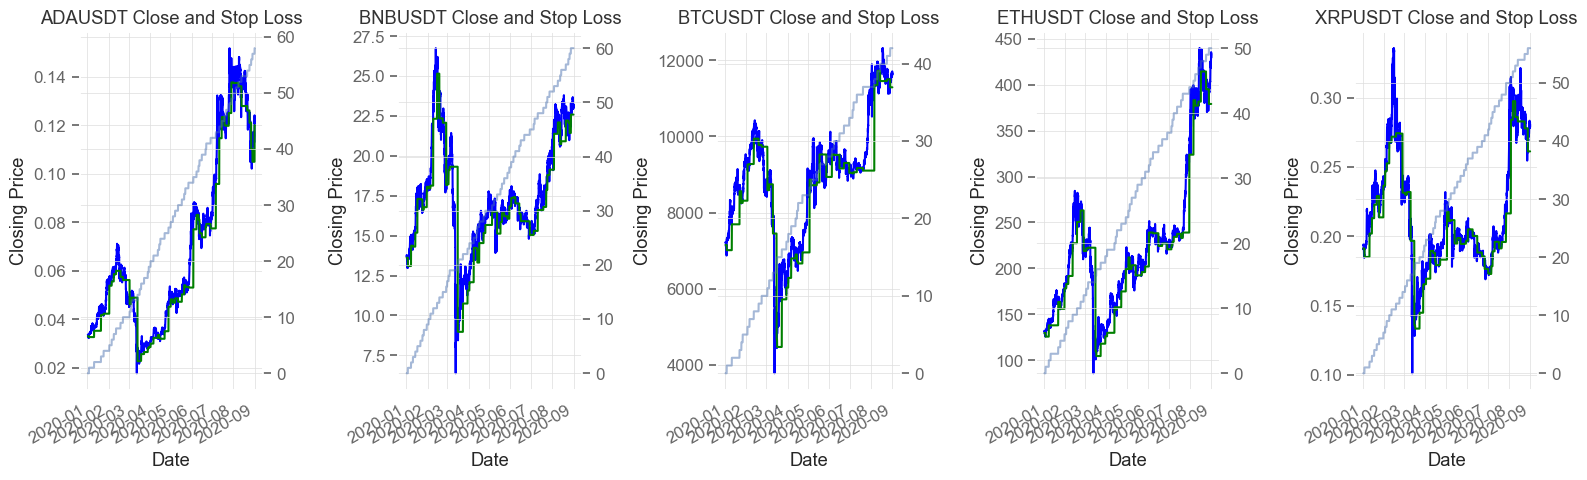

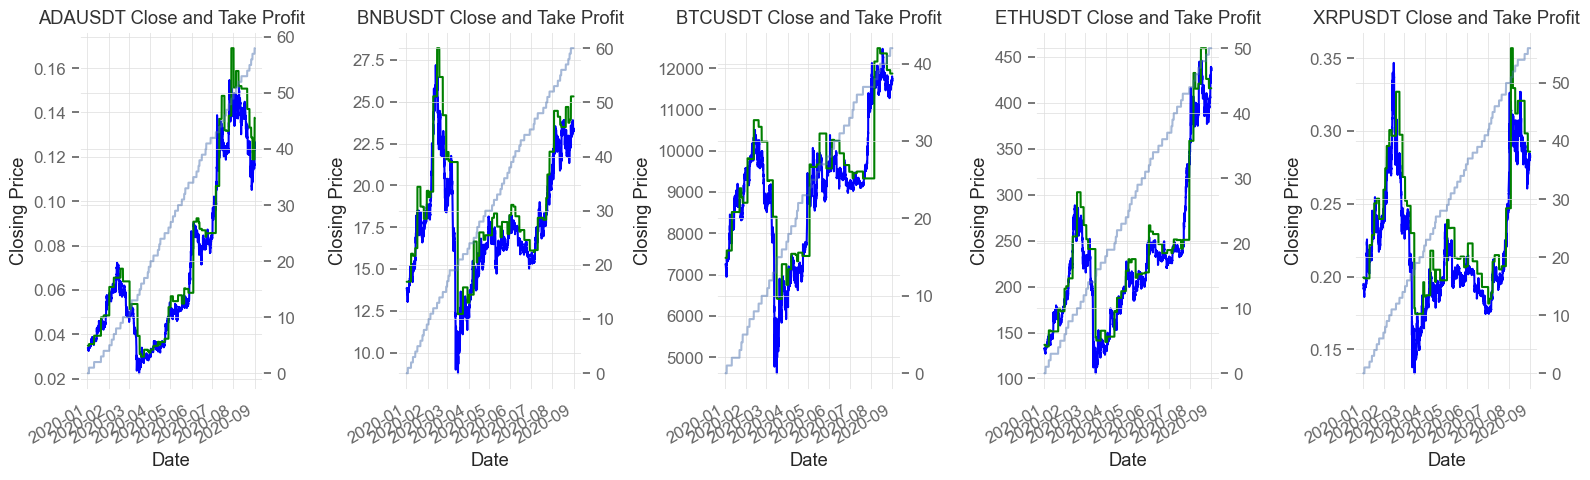

In [7]:
###### To Optimize ######
#All parameters:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling
low_freq_index = 1 #The index of the lowest frequency for the resampling
low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
max_dollar_allocation = 10000
std_window = 2
mean_window = 2
ema_window = 2
high_freq_index = 3 #The index of the highest frequency for the resampling
high_freq = all_frequency[high_freq_index] #The highest frequency for the resampling
str_length = 10
str_mult = 3
_min_pos = 0
_max_pos = 1
sl_type = 'atr'
sl_ind_length = 14
sl_ind_mult = 3
sl_signal_only = True
fixed_sl = True
tp_type = 'rr'
tp_mult = 2
tp_ind_length = 0
tp_signal_only = True
fixed_tp = True
max_perc_risk = 0.01




#Downsample the data
cal = Calculations()
#Generate a signal
tf = Trend_Following()

_df = tf.supertrend_signals(data, str_length, str_mult)

pos = Position(_df, _min_pos, _max_pos)
_df = pos.initialize_position()
sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
_df = sl.apply_stop_loss(fixed_sl, plot = True)
tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
_df = tp.apply_take_profit(fixed_tp, plot = True)

_df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
_df = pos.calculate_position(_df)

mt = Manage_Trade(_df)
_df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

#########################

_df = cal.update_all(_df)



In [8]:
_df['position']

date                        
2020-01-01 15:00:00  ADAUSDT    NaN
                     BNBUSDT    NaN
                     BTCUSDT    NaN
                     ETHUSDT    NaN
                     XRPUSDT    NaN
                               ... 
2020-08-31 23:00:00  ADAUSDT    1.0
                     BNBUSDT    1.0
                     BTCUSDT    1.0
                     ETHUSDT    0.0
                     XRPUSDT    1.0
Name: position, Length: 29145, dtype: float64

In [9]:
df = cal.downsample(_df, low_freq)

#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(df, max_dollar_allocation)
df = coarse.sort_by_volume(df)
df = coarse.sort_by_std(df, std_window, mean_window)
fine = Fine()
df = fine.above_ema(df, ema_window)

#apply update_univers
df['in_universe'], current_universe = update_universe(df)

C:\Users\yassi\AppData\Local\Temp\ipykernel_22912\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [10]:
df.dropna()

close  creturns         high  log_return  \
date                                                                          
2020-01-02 15:00:00 ADAUSDT      0.03317  1.011897      0.03329   -0.003311   
                    BNBUSDT     13.40440  0.978559     13.43610   -0.000082   
                    BTCUSDT   7130.98000  0.993585   7152.00000   -0.000646   
                    ETHUSDT    129.59000  1.005587    129.80000    0.001699   
                    XRPUSDT      0.19054  0.989921      0.19131   -0.002516   
...                                  ...       ...          ...         ...   
2020-08-31 23:00:00 ADAUSDT      0.12253  3.737950      0.12315    0.001634   
                    BNBUSDT     23.14770  1.689847     23.30670   -0.001407   
                    BTCUSDT  11649.51000  1.623168  11689.68000   -0.000161   
                    ETHUSDT    433.79000  3.366105    437.80000   -0.003061   
                    XRPUSDT      0.28115  1.460671      0.28359    0.000747   

                                     low         open        price   returns  \
date                                                                           
2020-01-02 15:00:00 ADAUSDT      0.03315      0.03329      0.03317 -0.003305   
                    BNBUSDT     13.35500     13.40190     13.40440 -0.000082   
                    BTCUSDT   7120.00000   7135.59000   7130.98000 -0.000646   
                    ETHUSDT    129.36000    129.37000    129.59000  0.001701   
                    XRPUSDT      0.19030      0.19102      0.19054 -0.002513   
...                                  ...          ...          ...       ...   
2020-08-31 23:00:00 ADAUSDT      0.12177      0.12233      0.12253  0.001635   
                    BNBUSDT     23.12460     23.17980     23.14770 -0.001406   
                    BTCUSDT  11647.61000  11651.39000  11649.51000 -0.000160   
                    ETHUSDT    433.70000    435.12000    433.79000 -0.003057   
                    XRPUSDT      0.28070      0.28095      0.28115  0.000747   

                                   volume  volume_in_dollars  ...  \
date                                                          ...   
2020-01-02 15:00:00 ADAUSDT  3.811639e+05       1.264321e+04  ...   
                    BNBUSDT  3.195121e+04       4.282868e+05  ...   
                    BTCUSDT  8.624297e+02       6.149969e+06  ...   
                    ETHUSDT  5.352620e+03       6.936461e+05  ...   
                    XRPUSDT  1.301272e+06       2.479443e+05  ...   
...                                   ...                ...  ...   
2020-08-31 23:00:00 ADAUSDT  7.149835e+06       8.760693e+05  ...   
                    BNBUSDT  7.473204e+04       1.729875e+06  ...   
                    BTCUSDT  1.554036e+03       1.810376e+07  ...   
                    ETHUSDT  3.991772e+04       1.731591e+07  ...   
                    XRPUSDT  5.809346e+06       1.633297e+06  ...   

                               htf_close    htf_volume  htf_volume_in_dollars  \
date                                                                            
2020-01-02 15:00:00 ADAUSDT      0.03269  4.282646e+07           1.405664e+06   
                    BNBUSDT     13.01050  9.711907e+05           1.298722e+07   
                    BTCUSDT   6965.71000  3.195148e+04           2.258280e+08   
                    ETHUSDT    127.19000  2.137571e+05           2.749587e+07   
                    XRPUSDT      0.18750  4.791211e+07           9.081044e+06   
...                                  ...           ...                    ...   
2020-08-31 23:00:00 ADAUSDT      0.12253  4.592725e+08           5.525868e+07   
                    BNBUSDT     23.14770  1.767388e+06           4.125484e+07   
                    BTCUSDT  11649.51000  5.535362e+04           6.464956e+08   
                    ETHUSDT    433.79000  1.040749e+06           4.478154e+08   
                    XRPUSDT      0.28115  1.645416e+08           4.630695e+07   

              

<Axes: xlabel='date,None'>

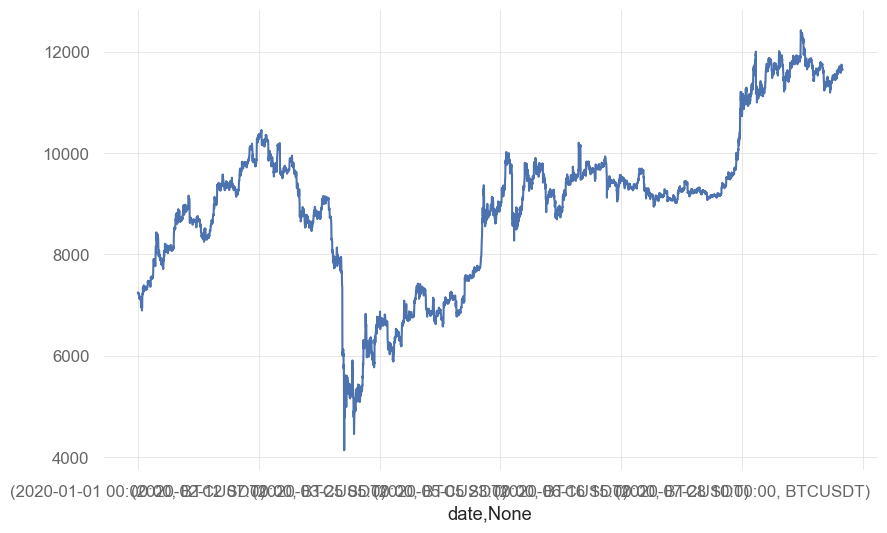

In [11]:
df.loc[(slice(None), 'BTCUSDT'), 'close'].plot()


In [12]:
df.dropna(inplace = True)

In [13]:
df = df[df['in_universe']]

#### Trading Strategy

In [14]:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling 

In [15]:
def trading_strategy(
        data,
        params = None,
        ###### To Optimize ######
        std_window = 20,
        mean_window = 20,
        ema_window = 20,
        str_length = 10,
        str_mult = 3,
        _min_pos = 0, #Has to be >= 0
        _max_pos = 1, #Has to be > 0
        sl_ind_length = 14,
        sl_ind_mult = 3,
        tp_mult = 2,
        ptp_mult = 1,
        ptp_exit_percent = 0.5,
        ###### Constants ######
        low_freq_index = 1, #The index of the lowest frequency for the resampling
        high_freq_index = 3, #The index of the highest frequency for the resampling
        max_perc_risk = 0.01,
        max_dollar_allocation = 10000,
        sl_type = 'atr',
        tp_type = 'rr',
        sl_signal_only = True,
        tp_signal_only = True,
        ptp_signal_only = True,
        tp_ind_length = 0,
        fixed_sl = True,
        fixed_tp = True
        ):
    
    if params is not None:
        if isinstance(params, list):
            std_window = params[0]
            mean_window = params[1]
            ema_window = params[2]
            str_length = params[3]
            str_mult = params[4]
            _min_pos = params[5]
            _max_pos = params[6]
            sl_ind_length = params[7]
            sl_ind_mult = params[8]
            tp_mult = params[9]
            ptp_mult = params[10]
            ptp_exit_percent = params[11]
        if isinstance(params, dict):
            std_window = params['std_window']
            mean_window = params['mean_window']
            ema_window = params['ema_window']
            str_length = params['str_length']
            str_mult = params['str_mult']
            _min_pos = params['_min_pos']
            _max_pos = params['_max_pos']
            sl_ind_length = params['sl_ind_length']
            sl_ind_mult = params['sl_ind_mult']
            tp_mult = params['tp_mult']
            ptp_mult = params['ptp_mult']
            ptp_exit_percent = params['ptp_exit_percent']
        


    if high_freq_index > low_freq_index:
        low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
        high_freq = all_frequency[high_freq_index], #The highest frequency for the resampling
            #Generally not going to be used since we are not calling the data inside the function
    
    
    cal = Calculations()
    #Generate a signal
    

    _df = tf.supertrend_signals(data.copy(), str_length, str_mult)

    pos = Position(_df, _min_pos, _max_pos)
    _df = pos.initialize_position()
    sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
    _df = sl.apply_stop_loss(fixed_sl, plot = False)
    tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
    _df = tp.apply_take_profit(fixed_tp, plot = False)
    ptp = Take_Profit(_df, tp_type, ptp_mult, ptp_signal_only, exit_percent = ptp_exit_percent)
    _df = ptp.apply_take_profit(fixed_tp, plot = False)

    _df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
    _df = pos.calculate_position(_df)

    mt = Manage_Trade(_df)
    _df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

    #########################

    _df = cal.update_all(_df)

    #Downsample the data
    df = cal.downsample(_df, low_freq)

    #Perform coarse analysis and filtering
    coarse = Coarse()
    df = coarse.volume_flag(df, max_dollar_allocation)
    df = coarse.sort_by_volume(df)
    df = coarse.sort_by_std(df, std_window, mean_window)
    fine = Fine()
    df = fine.above_ema(df, ema_window)

    #apply update_univers
    df['in_universe'], current_universe = update_universe(df)

    df.dropna(inplace = True)

    df = df[df['in_universe']]

    return df



In [16]:
sample_strategy = trading_strategy(data)
'strategy' in sample_strategy.columns

C:\Users\yassi\AppData\Local\Temp\ipykernel_22912\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


True

In [17]:
sample_strategy

close  creturns        high  log_return  \
date                                                                        
2020-01-04 05:00:00 ADAUSDT     0.03392  1.034777     0.03400    0.000590   
                    BTCUSDT  7344.69000  1.023362  7369.28000    0.001339   
                    ETHUSDT   133.66000  1.037169   134.11000   -0.000075   
                    XRPUSDT     0.19259  1.000571     0.19307    0.000364   
2020-01-04 06:00:00 ADAUSDT     0.03400  1.037218     0.03405    0.002356   
...                                 ...       ...         ...         ...   
2020-08-31 22:00:00 XRPUSDT     0.28094  1.459580     0.28219    0.007862   
2020-08-31 23:00:00 ADAUSDT     0.12253  3.737950     0.12315    0.001634   
                    BNBUSDT    23.14770  1.689847    23.30670   -0.001407   
                    ETHUSDT   433.79000  3.366105   437.80000   -0.003061   
                    XRPUSDT     0.28115  1.460671     0.28359    0.000747   

                                    low        open       price   returns  \
date                                                                        
2020-01-04 05:00:00 ADAUSDT     0.03385     0.03388     0.03392  0.000590   
                    BTCUSDT  7325.00000  7334.59000  7344.69000  0.001340   
                    ETHUSDT   133.40000   133.68000   133.66000 -0.000075   
                    XRPUSDT     0.19240     0.19255     0.19259  0.000364   
2020-01-04 06:00:00 ADAUSDT     0.03391     0.03391     0.03400  0.002358   
...                                 ...         ...         ...       ...   
2020-08-31 22:00:00 XRPUSDT     0.27863     0.27873     0.28094  0.007893   
2020-08-31 23:00:00 ADAUSDT     0.12177     0.12233     0.12253  0.001635   
                    BNBUSDT    23.12460    23.17980    23.14770 -0.001406   
                    ETHUSDT   433.70000   435.12000   433.79000 -0.003057   
                    XRPUSDT     0.28070     0.28095     0.28115  0.000747   

                                   volume  volume_in_dollars  ...   htf_close  \
date                                                          ...               
2020-01-04 05:00:00 ADAUSDT  1.174156e+06       3.982736e+04  ...     0.03434   
                    BTCUSDT  1.306739e+03       9.597591e+06  ...  7354.11000   
                    ETHUSDT  5.335128e+03       7.130932e+05  ...   134.20000   
                    XRPUSDT  1.460082e+06       2.811973e+05  ...     0.19305   
2020-01-04 06:00:00 ADAUSDT  9.896716e+05       3.364883e+04  ...     0.03434   
...                                   ...                ...  ...         ...   
2020-08-31 22:00:00 XRPUSDT  3.653565e+06       1.026433e+06  ...     0.28115   
2020-08-31 23:00:00 ADAUSDT  7.149835e+06       8.760693e+05  ...     0.12253   
                    BNBUSDT  7.473204e+04       1.729875e+06  ...    23.14770   
                    ETHUSDT  3.991772e+04       1.731591e+07  ...   433.79000   
                    XRPUSDT  5.809346e+06       1.633297e+06  ...     0.28115   

                               htf_volume  htf_volume_in_dollars  volume_flag  \
date                                                                            
2020-01-04 05:00:00 ADAUSDT  5.552875e+07           1.891563e+06            1   
                    BTCUSDT  2.998797e+04           2.197767e+08            1   
                    ETHUSDT  1.842762e+05           2.462182e+07            1   
                    XRPUSDT  3.423966e+07           6.591874e+06            1   
2020-01-04 06:00:00 ADAUSDT  5.552875e+07           1.891563e+06            1   
...                                   ...                    ...          ...   
2020-08-31 22:00:00 XRPUSDT  1.645416e+08           4.630695e+07            1   
2020-08-31 23:00:00 ADAUSDT  4.592725e+08           5.525868e+07            1   
                    BNBUSDT  1.767388e+06           4.125484e+07            1   
                    ETHUSDT  1.040749e+06           4.478154e+08            1   
    

In [18]:
# Define parameter space for optimization
param_space = {
    'std_window': Integer(5, 30),
    'mean_window': Integer(5, 30),
    'ema_window': Integer(5, 100),
    'str_length': Integer(5, 50),
    'str_mult': Integer(1, 5),
    '_min_pos': Real(0, 1),
    '_max_pos': Real(1, 5),
    'sl_ind_length': Integer(5, 50),
    'sl_ind_mult': Real(0.5, 5),
    'tp_mult': Integer(2, 7),
    'ptp_mult': Real(1, 2),
    'ptp_exit_percent': Real(0.1, 1)
}

In [19]:
time_diff = data.unstack().index.get_level_values(0)[1] - data.unstack().index.get_level_values(0)[0]
data_points_per_day = pd.Timedelta('1 day') // time_diff
print(f"Data points per day: {data_points_per_day}")

Data points per day: 24


In [20]:
pd.Timedelta('1 w')

Timedelta('7 days 00:00:00')

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
from skopt import gp_minimize
from skopt.space import Integer, Categorical, Real
import quantstats_lumi as qs
from collections.abc import Iterable




class WFO():
    def __init__(self, data, 
                 trading_strategy, 
                 param_grid, 
                 train_size, 
                 test_size, 
                 step_size, 
                 optimize_fn="grid",
                 objective = 'sharpe',
                 opt_freq = 'custom'):
        """
        This class performs a walk-forward optimization on a trading strategy.

        Parameters:
        data (pd.DataFrame): The historical data to be used for backtesting.
        trading_strategy (object): The trading strategy to be optimized.
        param_grid (dict): The grid of parameters to be optimized.
        train_size (int): The number of data points to be used for training.
        test_size (int): The number of data points to be used for testing.
        step_size (int): The number of data points to step forward in each iteration.
        optimize_fn (str): The optimization function to use ("grid" or "gp").
        objective (str): The objective function to maximize ("sharpe", "sortino", "calmar", "multiple").
        opt_period (str): The period to optimize over ['custom', 'daily', 'weekly', 'quarterly', 'semi-annually', 'yearly'].
        """
        self.data = data
        self.trading_strategy = trading_strategy
        self.param_grid = param_grid
        if opt_freq == 'custom':
            self.train_size = train_size
        else:
            self.train_size = train_size = self.opt_freq(opt_freq)
        self.test_size = test_size
        self.step_size = step_size
        self.optimize_fn = optimize_fn
        self.objective = objective
        
        if train_size > 0:
            self.minimum_train_size = self.min_train_test_size(train_size)
        else:
            raise ValueError("Train size must be greater than 0.")

        max_param = max(
        param.high if isinstance(param, (Integer, Real)) else max(param) #To handle all different cases
        for param in param_grid.values()
        )

        if step_size + train_size + test_size > len(data):
            raise ValueError("Invalid train, test, or step size.")
        elif (train_size < max_param or test_size < max_param):
            raise ValueError("Parameter range exceeds train size or Test size.")
        elif train_size < 1 or test_size < 1 or step_size < 1:
            raise ValueError("Train, test, and step size must be greater than 0.")
        elif test_size < train_size:
            raise ValueError("Test size must be greater or equal to train size.")
        elif self.minimum_train_size > train_size:
            train_size = self.minimum_train_size
            print(f"Adjusted train size to {train_size}")
    
        if optimize_fn not in ["grid", "gp"]:
            raise ValueError("Invalid optimization function")
        
                             

    #### Helper Methods ####
    def min_train_test_size(self, train_size):
        """
        Calculate the minimum test size based on the train size.
        """

        current_size = train_size
        result = []

        while len(result) == 0 or result is None:
            result = self.trading_strategy(self.data.iloc[:current_size])
            if len(result) != 0:
                break
            current_size *= 2
            

        return current_size - len(result)


        
    def dict_to_param_space(self, param_dict):
        """
        Converts a dictionary of parameters to a list of skopt parameters.
        """
        param_space = []
        for param_name, param_range in param_dict.items():
            if isinstance(param_range, Integer):
                param_space.append(Integer(param_range.low, param_range.high, name=param_name))
            elif isinstance(param_range, Real):
                param_space.append(Real(param_range.low, param_range.high, name=param_name))
            elif isinstance(param_range, Categorical):
                param_space.append(Categorical(param_range.categories, name=param_name))
            elif isinstance(param_range, range):
                param_space.append(Integer(min(param_range), max(param_range), name=param_name))
            else:
                raise ValueError(f"Invalid range for parameter '{param_name}': {param_range}")
        return param_space
        

    def convert_param_space(self, param_space, n_samples=10):
        """
        Converts a parameter dictionary with Integer and Real objects to an iterable format.

        Parameters:
            param_space (dict): Dictionary with Integer or Real objects as values.
            n_samples (int): Number of discrete samples to generate for Real values.
        
        Returns:
            dict: Parameter dictionary with iterable values.
        """
        converted = {}
        for key, value in param_space.items():
            if isinstance(value, Integer):
                # Generate a range of discrete integers
                converted[key] = list(range(value.low, value.high + 1))
            elif isinstance(value, Real):
                # Generate n_samples equally spaced values in the range
                converted[key] = list(np.linspace(value.low, value.high, n_samples))
            else:
                # Assume the parameter is already iterable
                converted[key] = value

        return converted

    

    def split_data(self, data, train_size, test_size, step_size):
        start = 0
        while start + train_size + test_size <= len(data):
            train = data.iloc[start:start + train_size]
            test = data.iloc[start + train_size:start + train_size + test_size]
            yield train, test
            start += step_size

    def objective_function(self, result):
        """
        Calculate the objective function for the optimization.

        Note that we have only included objective functions that we want to maximize.
        """
        if 'strategy' not in result.columns:
            print("No strategy column in result")
            return 0

        strategy = result['strategy'].apply(np.exp) - 1

        if strategy.sum() == 0:
            return 0

        if self.objective == "multiple":
            creturns = result['strategy'].cumsum().apply(np.exp)
            performance = creturns.iloc[-1]
        elif self.objective == "sharpe":
            performance = qs.stats.sharpe(strategy)
        elif self.objective == "sortino":
            performance = qs.stats.sortino(strategy)
        elif self.objective == "calmar": 
            performance = qs.stats.calmar(strategy)
        else:
            raise ValueError("Invalid objective function")

        return performance
    
    def opt_freq(self, opt_freq):
        time_diff = data.unstack().index.get_level_values(0)[1] - data.unstack().index.get_level_values(0)[0]

        if opt_freq == 'daily':
            return pd.Timedelta('1 day') // time_diff
        elif opt_freq == 'weekly':
            return pd.Timedelta('1 w') // time_diff
        elif opt_freq == 'monthly':
            return pd.Timedelta('1 m') // time_diff
        elif opt_freq == 'quarterly':
            return pd.Timedelta('3 m') // time_diff
        elif opt_freq == 'semi-annually':
            return pd.Timedelta('6 m') // time_diff
        elif opt_freq == 'yearly':
            return pd.Timedelta('1 y') // time_diff
        else:
            raise ValueError("Invalid optimization frequency")
    
    



    #### Optimization Methods ####
    def optimize_parameters_grid(self, train_data, param_space):
        #Check if the parameter space is iterable (for ParameterGrid compatibility)
        if not any([isinstance(param_range, Iterable) for param_range in param_space.values()]):
            param_grid = self.convert_param_space(param_space, n_samples=20)
        else:
            param_grid = param_space
        
        print([param_space])
        best_params = None
        best_objective = -np.inf
        for params in ParameterGrid(param_grid):
            print(params)
            # print(train_data)
            result = self.trading_strategy(train_data.copy(), params = params)
            if result is None or len(result) == 0:
                continue
            # print(result)
            objective = self.objective_function(result)
            print(objective)
            if objective > best_objective:
                best_objective = objective
                best_params = params
        return best_params

    def optimize_parameters_gp(self, train_data, param_space):

        if isinstance(param_space, dict):
            param_space = self.dict_to_param_space(param_space)

        def objective(param_space):
            result = self.trading_strategy(train_data.copy(), params = param_space)
            # Use negative performance because gp_minimize minimizes
            objective = self.objective_function(result) 
            print(objective)
            return -objective if not pd.isnull(objective) else 1e10  # Handle invalid values

        # Run gp_minimize
        result = gp_minimize(
            func=objective,
            dimensions=param_space,
            n_calls=10,  # Number of evaluations
            random_state=42,
        )
        
        # Extract the best parameters
        best_params = {dim.name: val for dim, val in zip(param_space, result.x)}
        print(best_params)
        print(result.x)
        return best_params

   
    def test_strategy(self, test_data, best_params):
        result = self.trading_strategy(test_data.copy(), **best_params)
        peformance = self.objective_function(result)
        return peformance, result


    def walk_forward_optimization(self):
        """
        Perform a walk-forward optimization on a dataset.
        """
        all_performance = []
        all_results = []
        for train, test in self.split_data(self.data, self.train_size, self.test_size, self.step_size):
            # Optimize on training data
            if self.optimize_fn == "grid":
                best_params = self.optimize_parameters_grid(train, self.param_grid)
            elif self.optimize_fn == "gp":
                best_params = self.optimize_parameters_gp(train, self.param_grid)
            
            # Test on out-of-sample data
            performance, result = self.test_strategy(test, best_params)
            print(f"Out-of-sample performance: {performance}")
            
            all_performance.append(performance)
            all_results.append(result)
        
        all_results = pd.concat(all_results)
        return all_performance, all_results


In [ ]:
wfo = WFO(data, 
            trading_strategy, 
            param_space, 
            train_size=2000, 
            test_size=2000, 
            step_size=2000, 
            optimize_fn="gp", 
            objective='calmar', 
            opt_freq='custom')

all_performance, all_results = wfo.walk_forward_optimization()

NameError: name 'WFO' is not defined

In [ ]:
def optimize_sizes(data, trading_strategy, param_space):
    best_performance = -np.inf
    for train_size in range(1000, 3001, 500):  # Adjust the step size as needed
        for test_size in range(1000, 3001, 500):
            for step_size in range(1000, 3001, 500):
                wfo = WFO(data, 
                        trading_strategy, 
                        param_space, 
                        train_size=train_size, 
                        test_size=test_size, 
                        step_size=step_size, 
                        optimize_fn="gp", 
                        objective='sharpe', 
                        opt_freq='custom')
                print(f"Train size: {train_size}, Test size: {test_size}, Step size: {step_size}")
                all_performance, all_results = wfo.walk_forward_optimization()
                if np.mean(all_performance) > best_performance:
                    best_performance = np.mean(all_performance)
                    best_train_size = train_size
                    best_test_size = test_size
                    best_step_size = step_size
                    best_results = all_results
                print(f"Mean performance: {np.mean(all_performance)}")

    return best_train_size, best_test_size, best_step_size, best_results, best_performance

optimize_sizes(data, trading_strategy, param_space)


In [60]:
np.mean(all_performance)

0.3465235965946321

In [61]:
all_results

close  creturns      high  log_return  \
date                                                                    
2020-01-15 02:00:00 BNBUSDT  17.13910  1.251203  17.14080    0.012494   
                    XRPUSDT   0.23700  1.231297   0.23968   -0.004589   
2020-01-15 03:00:00 BNBUSDT  16.87000  1.231558  17.16730   -0.015826   
                    XRPUSDT   0.23488  1.220283   0.23817   -0.008985   
2020-01-15 04:00:00 BNBUSDT  16.48430  1.203400  16.94130   -0.023128   
...                               ...       ...       ...         ...   
2020-08-30 00:00:00 BNBUSDT  23.07060  1.684219  23.10880    0.005686   
2020-08-30 01:00:00 BNBUSDT  23.13840  1.689169  23.21300    0.002934   
2020-08-30 02:00:00 BNBUSDT  23.01460  1.680131  23.14450   -0.005365   
2020-08-30 03:00:00 BNBUSDT  23.11960  1.687796  23.14190    0.004552   
2020-08-30 04:00:00 BNBUSDT  22.99170  1.678459  23.12910   -0.005547   

                                  low      open     price   returns  \
date                                                                  
2020-01-15 02:00:00 BNBUSDT  16.79900  16.92840  17.13910  0.012572   
                    XRPUSDT   0.23658   0.23809   0.23700 -0.004578   
2020-01-15 03:00:00 BNBUSDT  16.85330  17.13910  16.87000 -0.015701   
                    XRPUSDT   0.23451   0.23700   0.23488 -0.008945   
2020-01-15 04:00:00 BNBUSDT  16.46000  16.87060  16.48430 -0.022863   
...                               ...       ...       ...       ...   
2020-08-30 00:00:00 BNBUSDT  22.90000  22.94410  23.07060  0.005702   
2020-08-30 01:00:00 BNBUSDT  23.03800  23.07430  23.13840  0.002939   
2020-08-30 02:00:00 BNBUSDT  22.95000  23.13830  23.01460 -0.005350   
2020-08-30 03:00:00 BNBUSDT  23.00610  23.01460  23.11960  0.004562   
2020-08-30 04:00:00 BNBUSDT  22.97750  23.11840  22.99170 -0.005532   

                                 volume  volume_in_dollars  ...  \
date                                                        ...   
2020-01-15 02:00:00 BNBUSDT   159117.25       2.727126e+06  ...   
                    XRPUSDT  9525298.20       2.257496e+06  ...   
2020-01-15 03:00:00 BNBUSDT   136567.76       2.303898e+06  ...   
                    XRPUSDT  9907066.70       2.326972e+06  ...   
2020-01-15 04:00:00 BNBUSDT   174479.58       2.876174e+06  ...   
...                                 ...                ...  ...   
2020-08-30 00:00:00 BNBUSDT    88916.39       2.051354e+06  ...   
2020-08-30 01:00:00 BNBUSDT   111105.83       2.570811e+06  ...   
2020-08-30 02:00:00 BNBUSDT   109644.48       2.523424e+06  ...   
2020-08-30 03:00:00 BNBUSDT    61959.97       1.432490e+06  ...   
2020-08-30 04:00:00 BNBUSDT    74738.77       1.718371e+06  ...   

                             SUPERT_33_3.0  SUPERTd_33_3.0  SUPERTl_33_3.0  \
date                                                                         
2020-01-15 02:00:00 BNBUSDT            NaN             NaN             NaN   
                    XRPUSDT            NaN             NaN             NaN   
2020-01-15 03:00:00 BNBUSDT            NaN             NaN             NaN   
                    XRPUSDT            NaN             NaN             NaN   
2020-01-15 04:00:00 BNBUSDT            NaN             NaN             NaN   
...                                    ...             ...             ...   
2020-08-30 00:00:00 BNBUSDT            NaN             NaN             NaN   
2020-08-30 01:00:00 BNBUSDT            NaN             NaN             NaN   
2020-08-30 02:00:00 BNBUSDT            NaN             NaN             NaN   
2020-08-30 03:00:00 BNBUSDT            NaN             NaN             NaN   
2020-08-30 04:00:00 BNBUSDT            NaN             NaN             NaN   

                             SUPERTs_33_3.0  ema_99  SUPERT_45_3.0  \
date                                                                 
2020-01-15 02:00:00 BNBUSDT             NaN     NaN            NaN   
                    XRPUSDT             NaN     NaN          

<Axes: xlabel='date,None'>

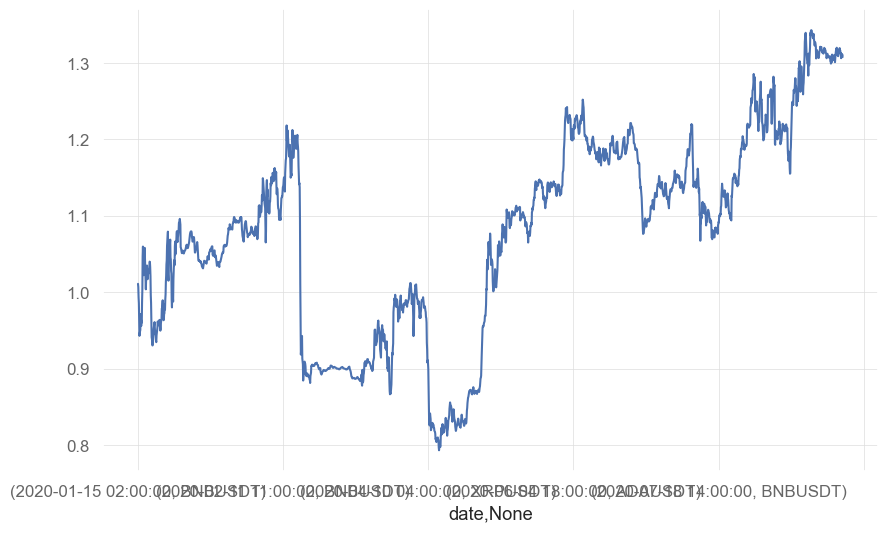

In [62]:
creturns = all_results['strategy'].cumsum().apply(np.exp)
creturns.plot()